In [35]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim

In [36]:
# Function to normalize image to [0, 1]
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

In [37]:
ayto_kmeans_path = './clustering/EsAytMadridOt2022ICU_clipped.tif'

In [77]:
np.seterr(invalid='ignore')

def analyze(k: int):
    # Open city hall raster
    with rasterio.open(ayto_kmeans_path) as src:
        ayto_no_data_value = src.nodata
        ayto_band = src.read(1)
        ayto_band = np.ma.masked_where(ayto_band == ayto_no_data_value, ayto_band)

    # Convert the city hall band into the same clusters as our own raster
    if k == 2:
        ayto_band = np.where(ayto_band <= 4, 1, 2)
    elif k == 4:
        ayto_band = np.ceil(ayto_band / 2).astype(int)
    else:
        ayto_band = ayto_band.astype(int)

    # Open our own raster
    own_kmeans_path = './clustering/FullYear_StudyArea_Kmeans_' + str(k) + '_clipped_resampled.tif'
    with rasterio.open(own_kmeans_path) as src:
        own_no_data_value = src.nodata
        own_band = src.read(1)
        own_band = np.ma.masked_where(own_band == own_no_data_value, own_band)

    # Compute SSIM
    ayto_band_normalized = normalize_image(ayto_band)
    own_band_normalized = normalize_image(own_band)
    
    ssim_value, ssim_map = ssim(ayto_band_normalized, own_band_normalized, data_range=1.0, full=True)

    # Plot two rasters
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the first image on the left
    ax1.imshow(ayto_band, cmap='plasma')
    ax1.axis('off')
    ax1.set_title('Madrid City Hall Study')
    
    # Display the second image on the right
    ax2.imshow(own_band, cmap='plasma')
    ax2.axis('off')
    ax2.set_title('Our Own Study')

    # Display the SSIM
    cax = ax3.imshow(ssim_map, cmap='gray')
    ax3.axis('off')
    ax3.set_title('SSIM Value='+str(ssim_value))
    
    fig.suptitle('K='+str(k), fontsize=16)
    
    # Show the plot
    plt.show()

In SSIM plots, darker values are close to -1 (less similarity) and lighter colors are close to 1 (greater similarity)

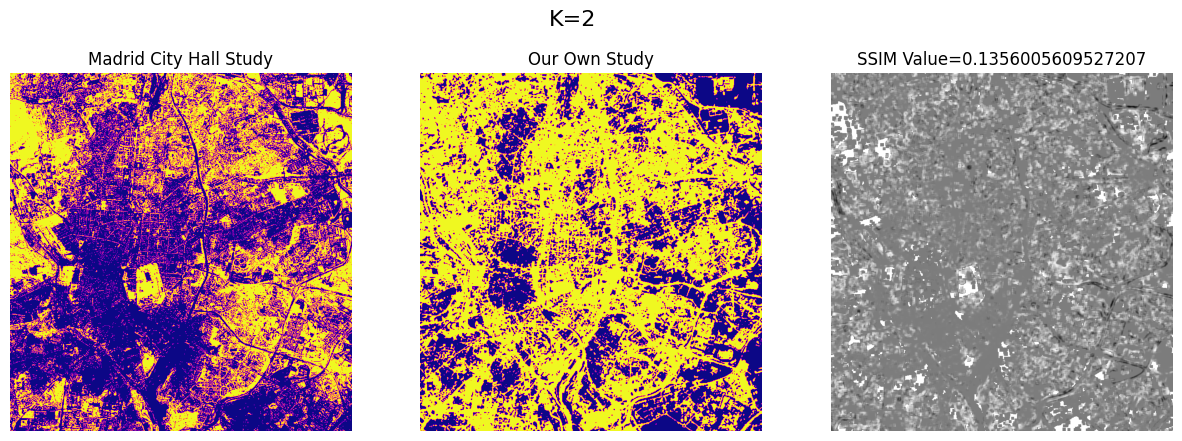

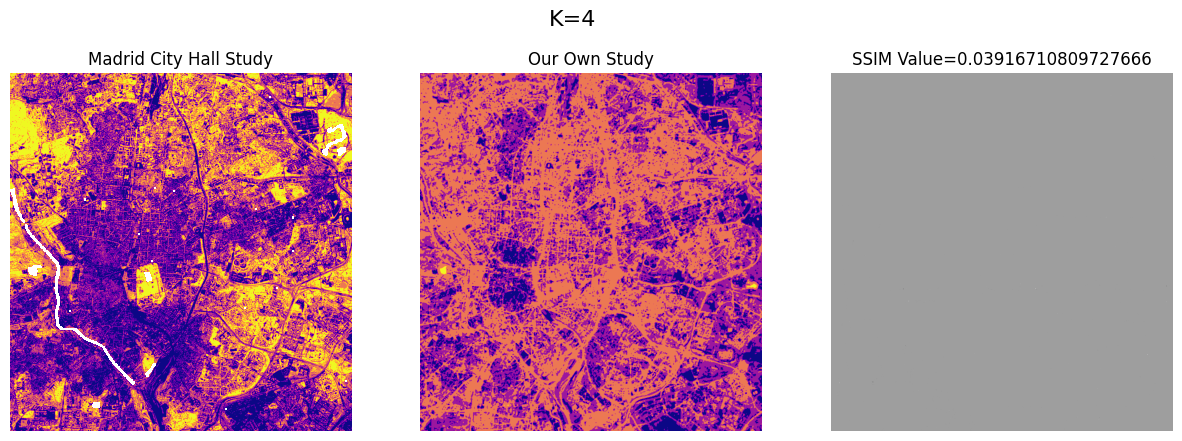

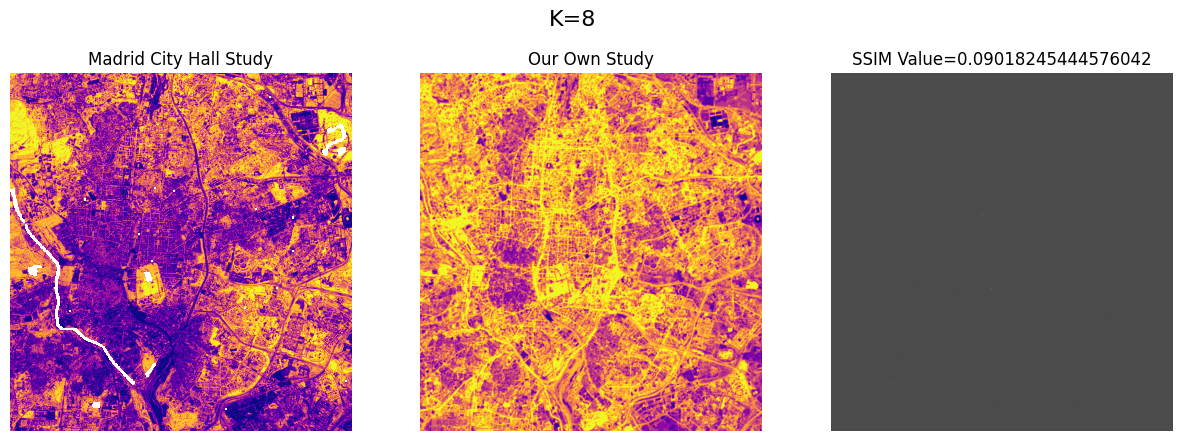

In [80]:
for k in [2, 4, 8]:  
    print('\n\n\n')
    analyze(k)